<center>
<h1> AWS Final Project </h1>
    <h2> Group B10 </h2>
    <h3> Walmart Sales Forecast </h3>
<hr>
<h1>Exploratory Data Analysis + Model building + Evaluation + Testing + Predictions</h1>
<hr>
 </center>

# Introduction
1. Libraries
2. Loading Data and merging into one dataset

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import boto3
import io
import datetime as dt
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso

In [11]:
s3 = boto3.resource('s3')
bucket_name = 'aws-ml-groupb10'

# Get the S3 bucket path
s3_path = 's3://{}/model-building/'.format(bucket_name)

# Connect to S3 bucket
s3 = boto3.resource('s3')
bucket_name = 'aws-ml-groupb10'
bucket = s3.Bucket(bucket_name)

In [12]:
# List all objects in the model-building folder
prefix = 'model-building/'
for obj in bucket.objects.filter(Prefix=prefix):
    print(obj.key)

model-building/
model-building/features.csv
model-building/stores.csv
model-building/train.csv


In [13]:
# Read the features CSV file from S3
features_key = 'model-building/features.csv'
features_obj = bucket.Object(features_key)
features_body = features_obj.get()['Body'].read().decode('utf-8')
features = pd.read_csv(io.StringIO(features_body))

# Read the stores CSV file from S3
stores_key = 'model-building/stores.csv'
stores_obj = bucket.Object(stores_key)
stores_body = stores_obj.get()['Body'].read().decode('utf-8')
stores = pd.read_csv(io.StringIO(stores_body))

# Read the train CSV file from S3
train_key = 'model-building/train.csv'
train_obj = bucket.Object(train_key)
train_body = train_obj.get()['Body'].read().decode('utf-8')
train = pd.read_csv(io.StringIO(train_body))

In [14]:
dataset = train.merge(stores, how='left').merge(features, how='left')
dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


# Plots // Data Exploration

In [15]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)

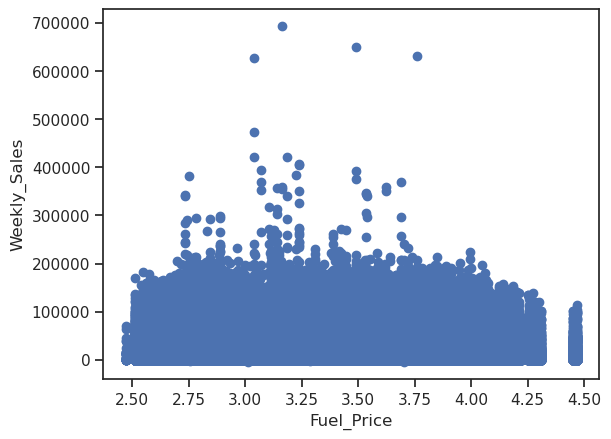

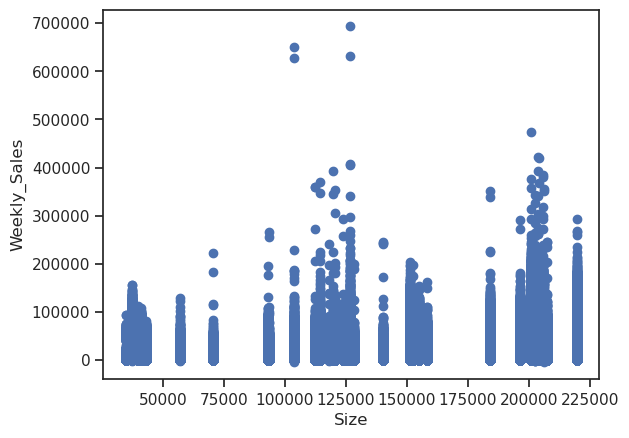

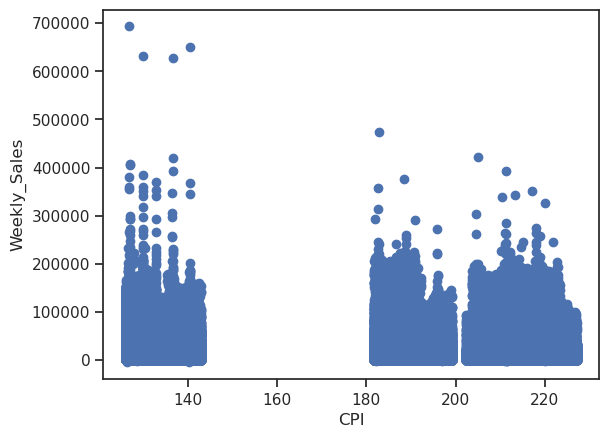

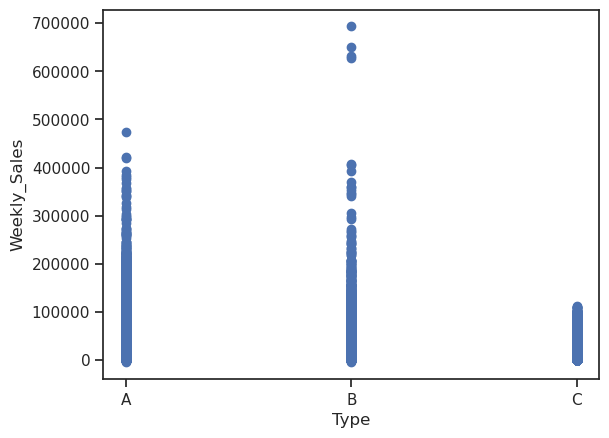

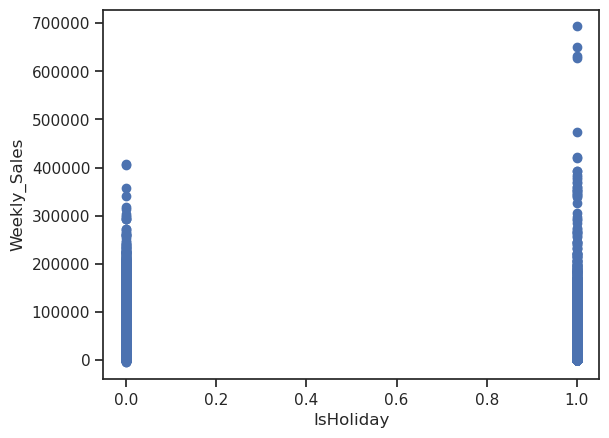

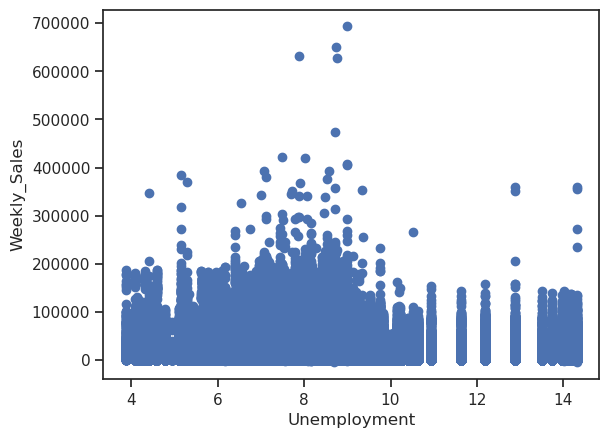

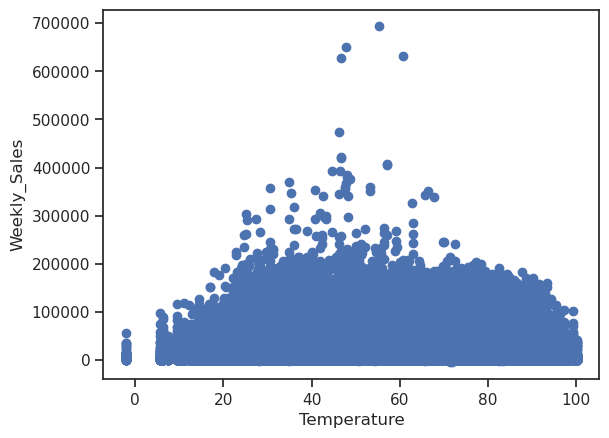

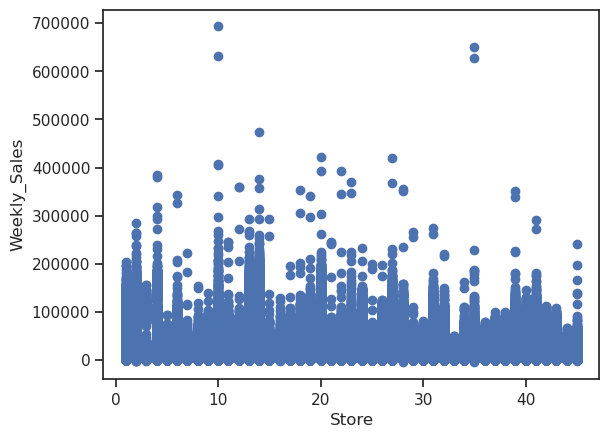

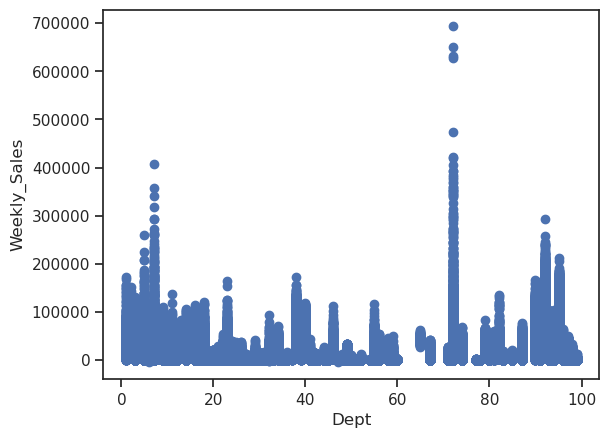

In [16]:
scatter(dataset, 'Fuel_Price')
scatter(dataset, 'Size')
scatter(dataset, 'CPI')
scatter(dataset, 'Type')
scatter(dataset, 'IsHoliday')
scatter(dataset, 'Unemployment')
scatter(dataset, 'Temperature')
scatter(dataset, 'Store')
scatter(dataset, 'Dept')

/tmp/ipykernel_30739/2054089924.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataset.corr()


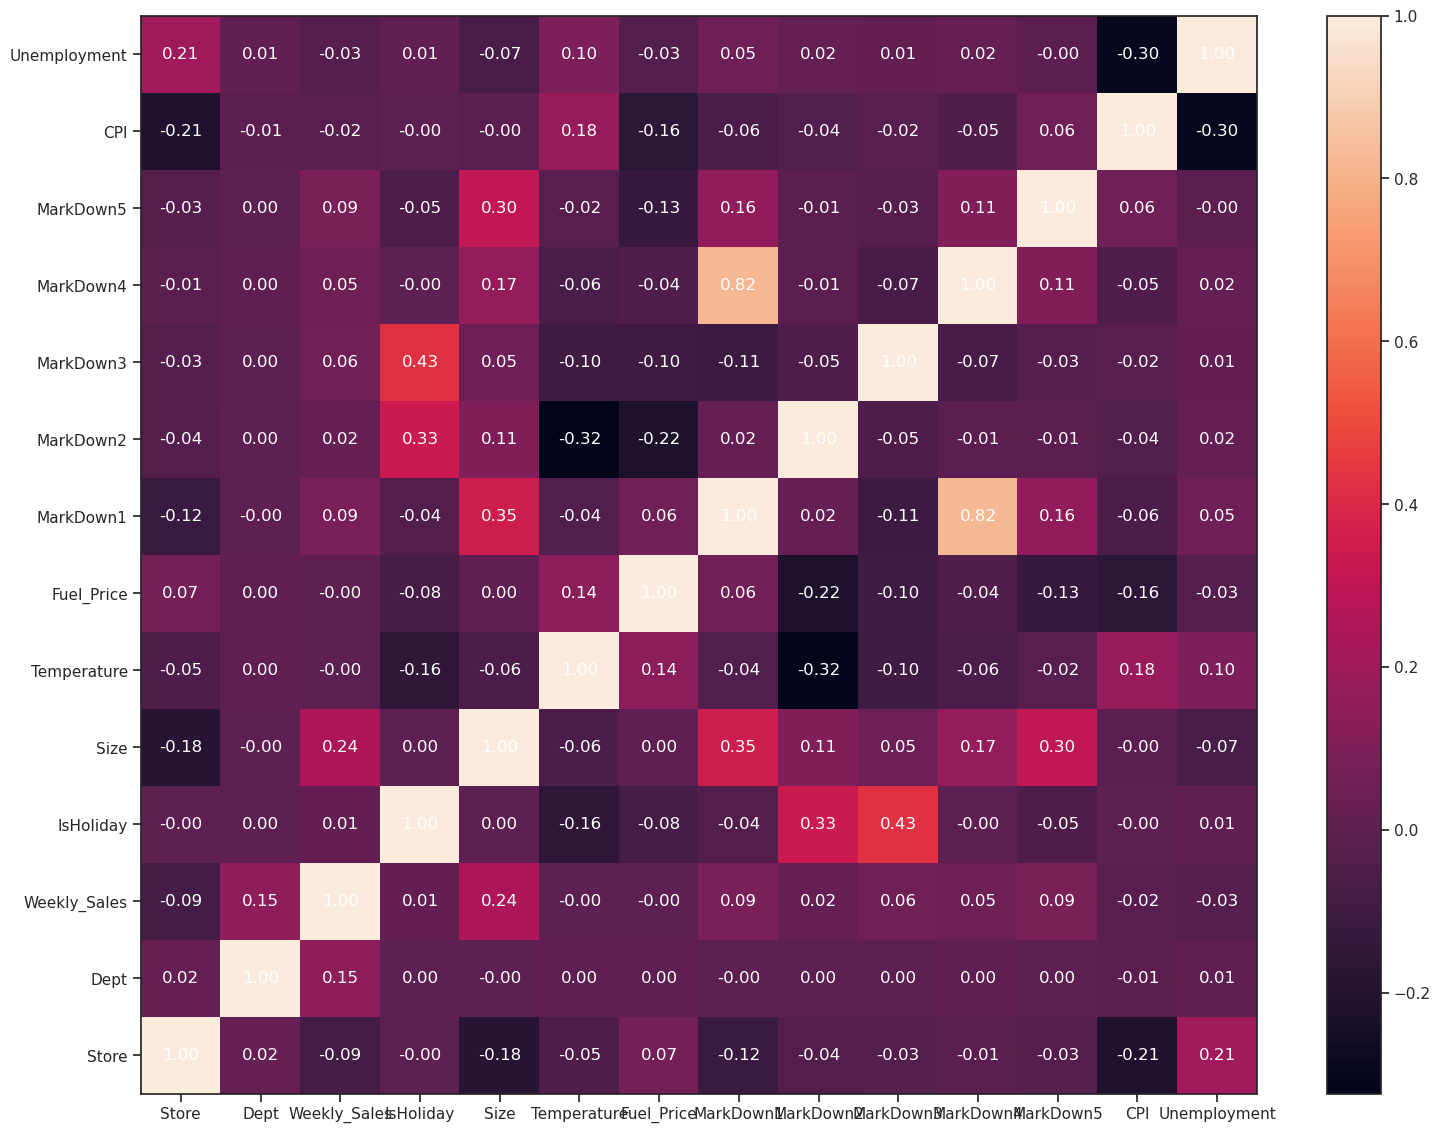

In [18]:
fig = plt.figure(figsize=(18, 14))
corr = dataset.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(j + 0.5, i + 0.5, '{:.2f}'.format(corr.iloc[i, j]), color='white', ha='center', va='center')

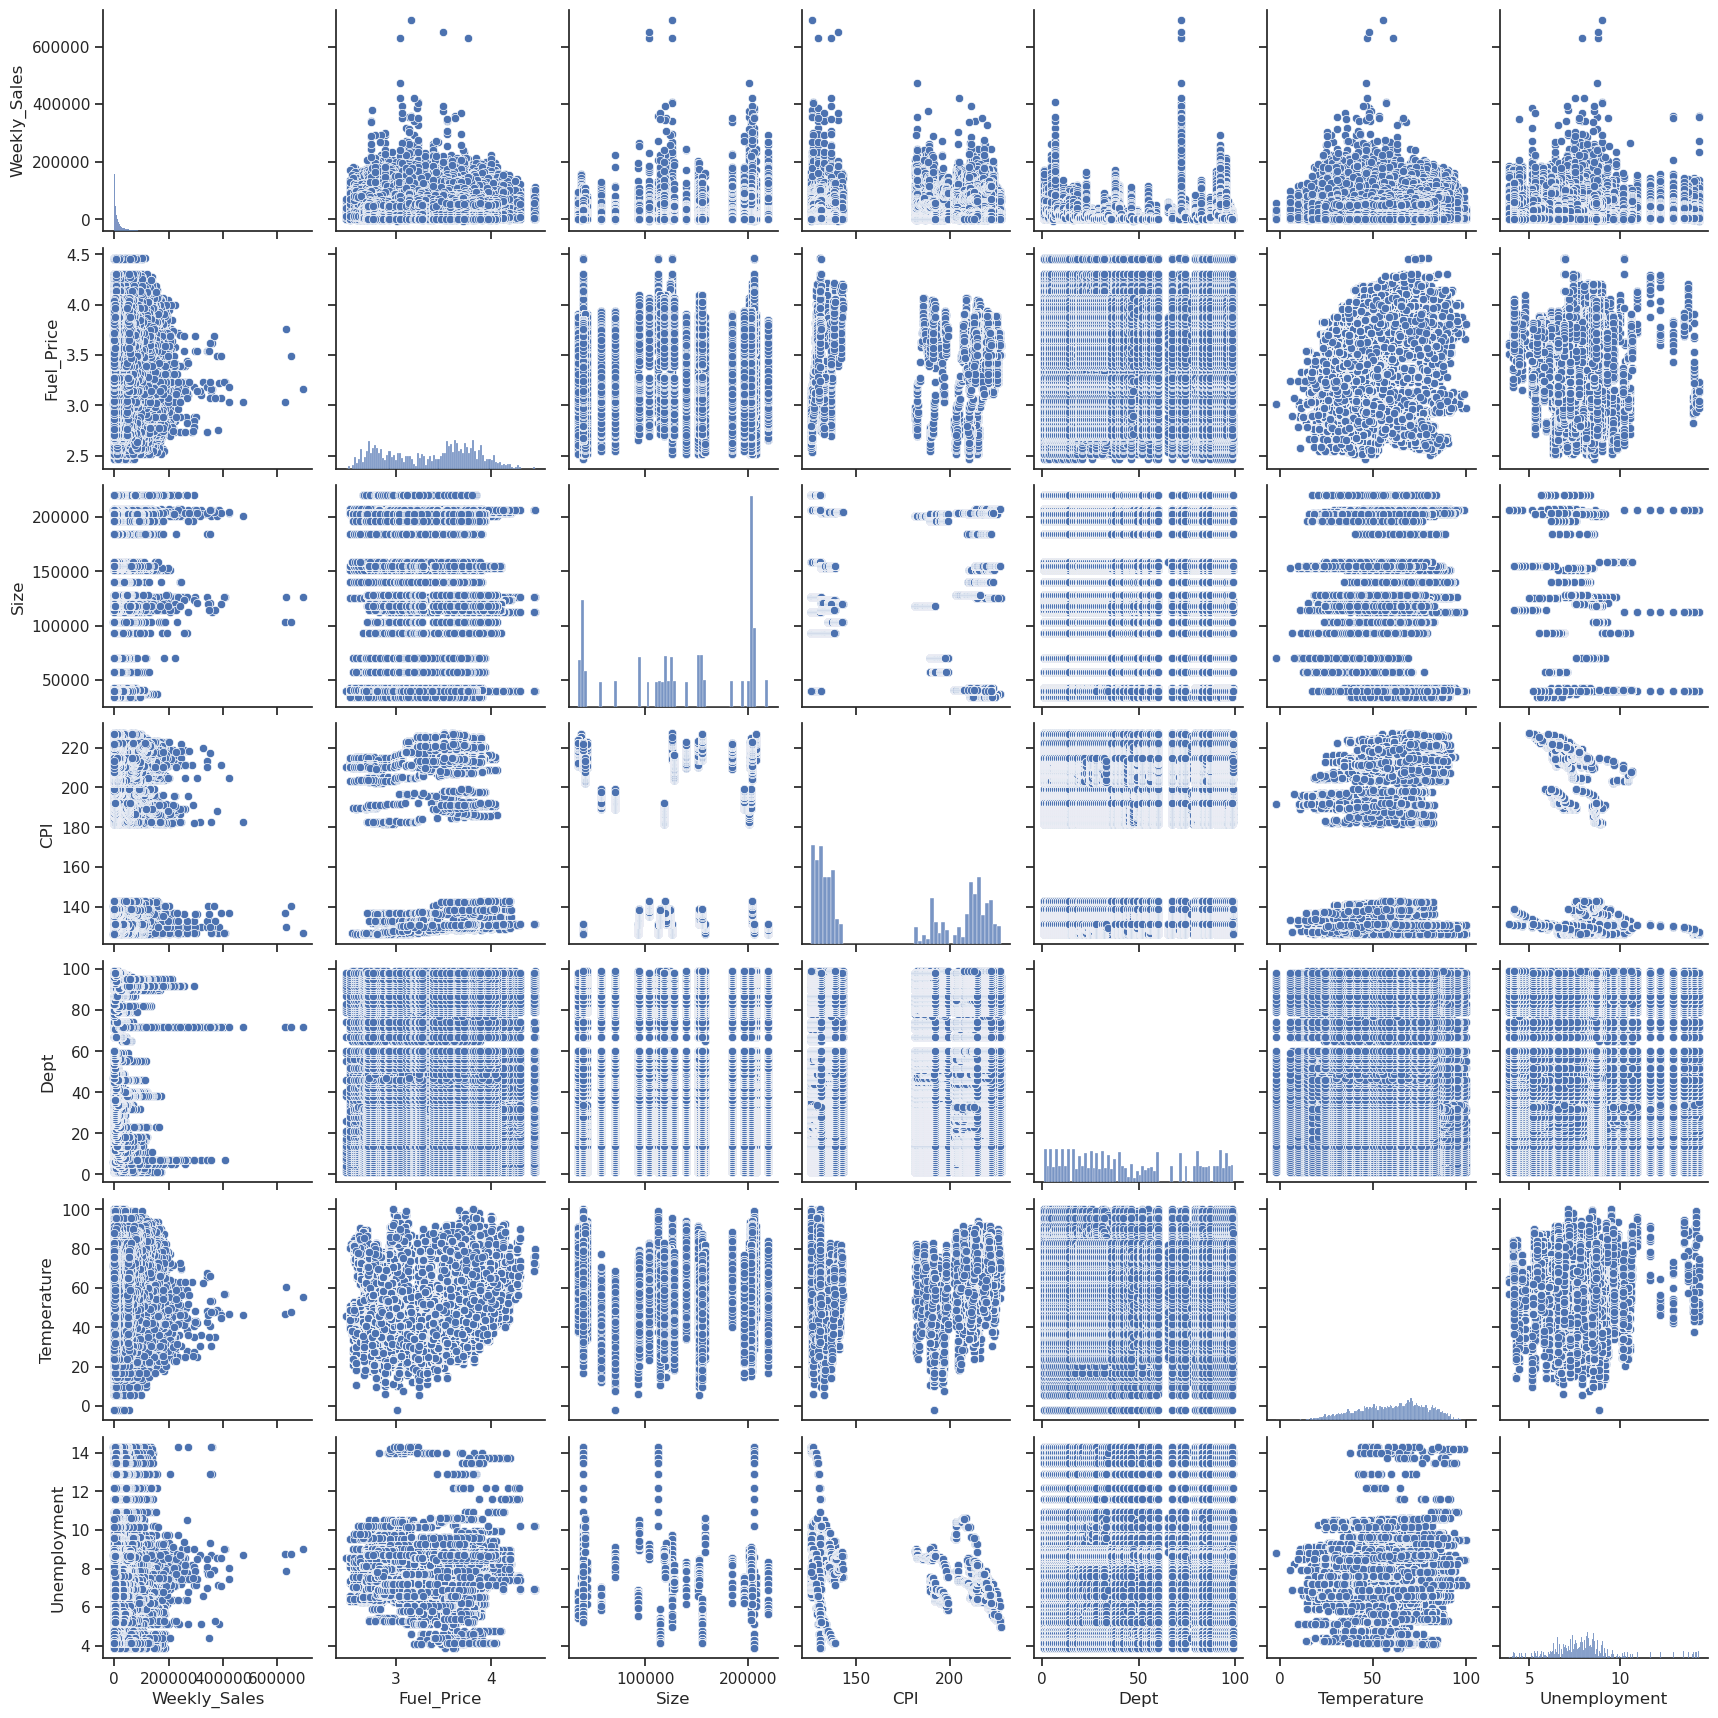

In [19]:
sns.pairplot(dataset, vars=['Weekly_Sales', 'Fuel_Price', 'Size', 'CPI', 'Dept', 'Temperature', 'Unemployment'])

# Data Manipulation

In [20]:
dataset = pd.get_dummies(dataset, columns=["Type"])
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment','MarkDown4'])

In [21]:
dataset

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,24924.50,False,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2
1,1,1,46039.49,True,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2
2,1,1,41595.55,False,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2
3,1,1,19403.54,False,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2
4,1,1,21827.90,False,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,508.37,False,118221,64.88,4556.61,20.64,1.50,3288.25,0,1,0,9
421566,45,98,628.10,False,118221,64.89,5046.74,0.00,18.82,2340.01,0,1,0,10
421567,45,98,1061.02,False,118221,54.47,1956.28,0.00,7.89,3990.54,0,1,0,10
421568,45,98,760.01,False,118221,56.47,2004.02,0.00,3.18,1537.49,0,1,0,10


In [22]:
dataset.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,Type_A,Type_B,Type_C,Month
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,2590.074819,879.974298,468.087665,1662.772385,0.511132,0.387824,0.101044,6.449510
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,6052.385934,5084.538801,5528.873453,4207.629321,0.499877,0.487255,0.301387,3.243217
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,0.000000,-265.760000,-29.100000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,2809.050000,2.200000,4.540000,2168.040000,1.000000,1.000000,0.000000,9.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,88646.760000,104519.540000,141630.610000,108519.280000,1.000000,1.000000,1.000000,12.000000


# Algorithms

In [23]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators=100,max_features='log2', verbose=1,n_jobs=-1)
    return clf

def svm():
    clf = SVR(kernel='rbf', gamma='auto')
    return clf

def nn():
    clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
    return clf

def lightgbm():
    lgbm = LGBMRegressor()
    return lgbm

def ridge_regression():
    ridge = Ridge(alpha=1.0)
    return ridge

def lasso_regression():
    lasso = Lasso(alpha=1.0)
    return lasso

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
    return lightgbm()
#    return ridge_regression()
#    return lasso_regression()
#    return knn()
#    return extraTreesRegressor()
#    return svm()
#    return nn()
#    return randomForestRegressor()    

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m
#

def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)

# K fold Cross Validation

In [24]:
kf = KFold(n_splits=5)
splitted = []
# dataset2 = dataset.copy()
for name, group in dataset.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splitted.append(group)

splitted = pd.concat(splitted).reset_index(drop=True)
splitted

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,Type_A,Type_B,Type_C,Month,fold
0,1,1,24924.50,False,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2,0.0
1,1,1,46039.49,True,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2,0.0
2,1,1,41595.55,False,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2,0.0
3,1,1,19403.54,False,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2,0.0
4,1,1,21827.90,False,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421269,45,98,508.37,False,118221,64.88,4556.61,20.64,1.50,3288.25,0,1,0,9,4.0
421270,45,98,628.10,False,118221,64.89,5046.74,0.00,18.82,2340.01,0,1,0,10,4.0
421271,45,98,1061.02,False,118221,54.47,1956.28,0.00,7.89,3990.54,0,1,0,10,4.0
421272,45,98,760.01,False,118221,56.47,2004.02,0.00,3.18,1537.49,0,1,0,10,4.0


In [25]:
best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(5):
    dataset_train = splitted.loc[splitted['fold'] != fold]
    dataset_test = splitted.loc[splitted['fold'] == fold]
    train_y = dataset_train['Weekly_Sales']
    train_x = dataset_train.drop(columns=['Weekly_Sales', 'fold'])
    test_y = dataset_test['Weekly_Sales']
    test_x = dataset_test.drop(columns=['Weekly_Sales', 'fold'])
    print(dataset_train.shape, dataset_test.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
    weights = test_x['IsHoliday'].replace(True, 5).replace(False, 1)
    error = calculate_error(test_y, predicted, weights)
    error_cv += error
    print(fold, error)
    if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model
error_cv /= 5

(335722, 15) (85552, 15)
0 4147.062886698795
Find best model
(335849, 15) (85425, 15)
1 5007.599868116458
(335970, 15) (85304, 15)
2 3830.6626357560885
Find best model
(338733, 15) (82541, 15)
3 4854.458764334058
(338822, 15) (82452, 15)
4 4057.8443612796573


# Test

In [26]:
# Read the test CSV file from S3
test_key = 'to-predict/test.csv'
test_obj = bucket.Object(test_key)
test_body = test_obj.get()['Body'].read().decode('utf-8')

test = pd.read_csv(io.StringIO(test_body))
dataset_test = test
dataset_test = dataset_test.merge(stores, how='left').merge(features, how='left')
dataset_test

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN
115060,45,98,2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN
115061,45,98,2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN
115062,45,98,2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN


In [27]:
dataset_test = pd.get_dummies(dataset_test, columns=["Type"])
dataset_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset_test = dataset_test.fillna(0)
column_date = dataset_test['Date']
dataset_test['Month'] = pd.to_datetime(dataset_test['Date']).dt.month
dataset_test = dataset_test.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown4'])
dataset_test

,Store,Dept,IsHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,False,151315,55.32,6766.44,5147.70,50.82,2737.42,1,0,0,11
1,1,1,False,151315,61.24,11421.32,3370.89,40.28,6154.16,1,0,0,11
2,1,1,False,151315,52.92,9696.28,292.10,103.78,6612.69,1,0,0,11
3,1,1,True,151315,56.23,883.59,4.17,74910.32,303.32,1,0,0,11
4,1,1,False,151315,52.34,2460.03,0.00,3838.35,6966.34,1,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,False,118221,76.05,4842.29,975.03,3.00,3169.69,0,1,0,6
115060,45,98,False,118221,77.50,9090.48,2268.58,582.74,1514.93,0,1,0,7
115061,45,98,False,118221,79.37,3789.94,1827.31,85.72,2150.36,0,1,0,7
115062,45,98,False,118221,82.84,2961.49,1047.07,204.19,1059.46,0,1,0,7


In [28]:
# Predict sales using the model
predicted_test = best_model.predict(dataset_test)

In [29]:
predicted_test

array([22996.79498107, 22674.16477886, 23148.83984171, ...,
        2121.46970174,  2121.46970174,  1333.97065502])

In [30]:
# Create new dataset 
dataset_test['weeklySales'] = predicted_test
dataset_test['Date'] = column_date
dataset_test['id'] = dataset_test['Store'].astype(str) + '_' +  dataset_test['Dept'].astype(str) + '_' +  dataset_test['Date'].astype(str)
dataset_test = dataset_test[['id', 'weeklySales']]
dataset_test = dataset_test.rename(columns={'id': 'Id', 'weeklySales': 'Weekly_Sales'})

In [31]:
dataset_test

,Id,Weekly_Sales
0,1_1_2012-11-02,22996.794981
1,1_1_2012-11-09,22674.164779
2,1_1_2012-11-16,23148.839842
3,1_1_2012-11-23,27176.621406
4,1_1_2012-11-30,27358.395923
...,...,...
115059,45_98_2013-06-28,1333.970655
115060,45_98_2013-07-05,3071.217952
115061,45_98_2013-07-12,2121.469702
115062,45_98_2013-07-19,2121.469702


In [32]:
s3 = boto3.client('s3')

#Save the model information as a text file in the S3 bucket
current_time = dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Create the output text
# Create the output text
output_text = "error_cv: {}\nbest_model: {}\nbest_error: {}\n".format(error_cv, best_model, best_error)
output_text += "Average MAE: {}\n".format(error_cv)
output_text += "Best MAE: {}\n".format(best_error)

# Save the output text to a file in the S3 bucket
output_key = "output/output_{}.txt".format(current_time)
s3.put_object(Bucket=bucket_name, Key=output_key, Body=output_text)
# Save the predictions as a CSV file in the S3 bucket

file_name = "predictions_{}.csv".format(current_time)
csv_buffer = io.StringIO()
dataset_test.to_csv(csv_buffer, index=False)
s3.put_object(Bucket=bucket_name, Key="output/{}".format(file_name), Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'GY193WYT4ZEW8AQK',
  'HostId': 'cW5EDWn0tCMdss/ux97SP0aPeZStlHAqbDPeWz/TaUxOe73VV15MQzZZoWR4zEw8Op7QBG7feEo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'cW5EDWn0tCMdss/ux97SP0aPeZStlHAqbDPeWz/TaUxOe73VV15MQzZZoWR4zEw8Op7QBG7feEo=',
   'x-amz-request-id': 'GY193WYT4ZEW8AQK',
   'date': 'Tue, 14 Mar 2023 19:58:25 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"1c372934dfce114f4295478bcd0be772"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1c372934dfce114f4295478bcd0be772"',
 'ServerSideEncryption': 'AES256'}